# Diabetes Medication
The idea for this part is to include what kind of diabetes medication that the patient might take, which also might alter the a1c. This data can be used in two ways:
* __Predicting Diabetes__  
  This variable together with fasting glucose, a1c, diabetes questionnaire are used to determine the target variable, then dropped to ensure no leakage.  
* __Predicting A1C (natural)__  
  If the target is to understand the natural factor that affect a1c, then might drop the row for any treated patients.
* __Predicting A1C (all factor)__  
  Can be used as either as factor for more details, or make it as simple as treated vs untreated.

### Algorithm
Step 1 - Import drug class table (manual work in excel)  
Step 2 - Lookup and split the drug combination if any  
Step 3 - From the drug list, binarize it  
Step 4 - Summarize the binarized data to handle multiple records  
Step 5 - Merge with the full data

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer

In [2]:
# convert XPT files to pandas dataframe
def xpt_to_df(file_path):
    df = pd.read_sas(file_path, format='xport', encoding='utf-8')
    return df

Step 1 - Import drug class table (manual work in excel)  

In [3]:
P_RXQ_RX = xpt_to_df('INPUTS/UNPROCESSED/P_RXQ_RX.XPT')
DIAMED_TAB = pd.read_excel("TABLES/DIAMED_TAB.xlsx", sheet_name="DIAMED_TAB")

Step 2 - Lookup and split the drug combination if any  

In [4]:
drug_dict = dict(zip(DIAMED_TAB["DRUG_NAME"].str.upper(), DIAMED_TAB["DRUG_CLASS"]))

def find_drug_class(drug_name):
    if not isinstance(drug_name, str):
        return []
    parts = [x.strip().upper() for x in drug_name.split(';')]
    return [drug_dict[p] for p in parts if p in drug_dict]

Step 3 - From the drug list, binarize it  

In [5]:
P_RXQ_RX['drug_classes'] = P_RXQ_RX['RXDDRUG'].apply(find_drug_class)

# One-hot encode the list of drug classes
mlb = MultiLabelBinarizer()
encoded = mlb.fit_transform(P_RXQ_RX['drug_classes'])
encoded_df = pd.DataFrame(encoded, columns=mlb.classes_, index=P_RXQ_RX.index)

# Combine with original DataFrame
P_RXQ_RX = pd.concat([P_RXQ_RX, encoded_df], axis=1)

Step 4 - Summarize the binarized data to handle multiple records  

In [6]:
cols = ['SEQN'] + list(mlb.classes_)
P_RXQ_RX_summary = P_RXQ_RX[cols].groupby("SEQN", as_index=False).max() # groupby to summarize the SEQN, then max to indicate presence of drug class
P_RXQ_RX_summary.to_csv("INPUTS/CSV/DIAMED.csv", index=False)

Step 5 - Merge with the full data

In [7]:
df = pd.read_csv("INPUTS/CSV/merged.csv")
df = df.merge(P_RXQ_RX_summary, on="SEQN", how="left")
df.to_csv("INPUTS/CSV/merged_with_DIAMED.csv", index=False)

C:\Users\victo\AppData\Local\Temp\ipykernel_20596\2465083216.py:1: DtypeWarning: Columns (655,656,657,658,660,662,663,667,669,670,671,672,673,674,675,676,677,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("INPUTS/CSV/merged.csv")


In [25]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, FunctionTransformer
from sklearn.ensemble import RandomForestRegressor

target = 'LBXGH'
drop_cols = ['SEQN', target, 'LBXGLU', 'LBDGLUSI', 'P_GHB.xpt_LBXGH', 'LBDSGLSI', 'LBXSGL', 
             'DIQ010', 'DID040', 'DIQ050', 'DID060', 'DIQ060U', 'DIQ070', 'DID260', 'DIQ280', 'DIQ300D']

df_cleaned = df.copy()
y = pd.to_numeric(df_cleaned[target], errors='coerce')
mask = y.notna()
y = y[mask]
X = df_cleaned.loc[mask].drop(columns=drop_cols, errors='ignore')

numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
])

categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),           # no NaNs left
    ('to_str', FunctionTransformer(lambda X: X.astype(str), 
                                   feature_names_out='one-to-one')),  # <- unify types
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
])

preprocess = ColumnTransformer(
    transformers=[
        ('num', numeric_pipeline, make_column_selector(dtype_include=np.number)),
        ('cat', categorical_pipeline, make_column_selector(dtype_exclude=np.number)),
    ],
    remainder='drop'
)

model = Pipeline(steps=[
    ('prep', preprocess),
    ('rf', RandomForestRegressor(n_estimators=400, random_state=42, n_jobs=-1)),
])

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit
model.fit(X_train, y_train)

# Predict````
y_pred = model.predict(X_test)

# Compute RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", rmse)


c:\Users\victo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: ['RIDAGEMN' 'DRQSDT5' 'AUQ011' 'AUQ540' 'AUQ550' 'AUQ550A' 'AUQ550B'
 'AUQ550C' 'AUQ550D' 'AUQ550E' 'AUQ560' 'AUQ570' 'AUQ580' 'AUQ590'
 'AUQ600' 'AUQ610' 'AUQ051' 'BMXRECUM' 'BMIRECUM' 'BMXHEAD' 'BMIHEAD'
 'LBXIGG' 'LBXIGM' 'LBXIGGA' 'P_CBQPFC.xpt_CBQ698CD' 'DBQ010' 'DBD030'
 'DBD041' 'DBD050' 'DBD055' 'DBD061' 'DBQ073A' 'DBQ073B' 'DBQ073C'
 'DBQ073D' 'DBQ073E' 'DBQ073U' 'FSQ653' 'FSD660ZC' 'FSD675' 'FSD680'
 'FSD670ZC' 'FSQ690' 'FSQ695' 'MCQ149' 'MCQ151' 'RHD018' 'OSD030BF'
 'OSQ040BF' 'OSQ100J' 'OSD110J']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
c:\Users\victo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: ['RIDAGEMN' 'DRQSDT5' 'AUQ011' 'AUQ540' 'AUQ550' 'AUQ550A' 'AUQ5

RMSE: 0.7764578566357718


             Feature  Importance
1855  num__Biguanide    0.142772
1858    num__Insulin    0.142551
1395    num__DIQ300S    0.059292
3      num__RIDAGEYR    0.040535
1389     num__DIQ230    0.035935
...              ...         ...
1075     num__LBXVDE    0.000000
1576    num__OHQ576U    0.000000
1574    num__OHQ576G    0.000000
1076   num__LBDVDELC    0.000000
0      num__SDDSRVYR    0.000000

[1955 rows x 2 columns]


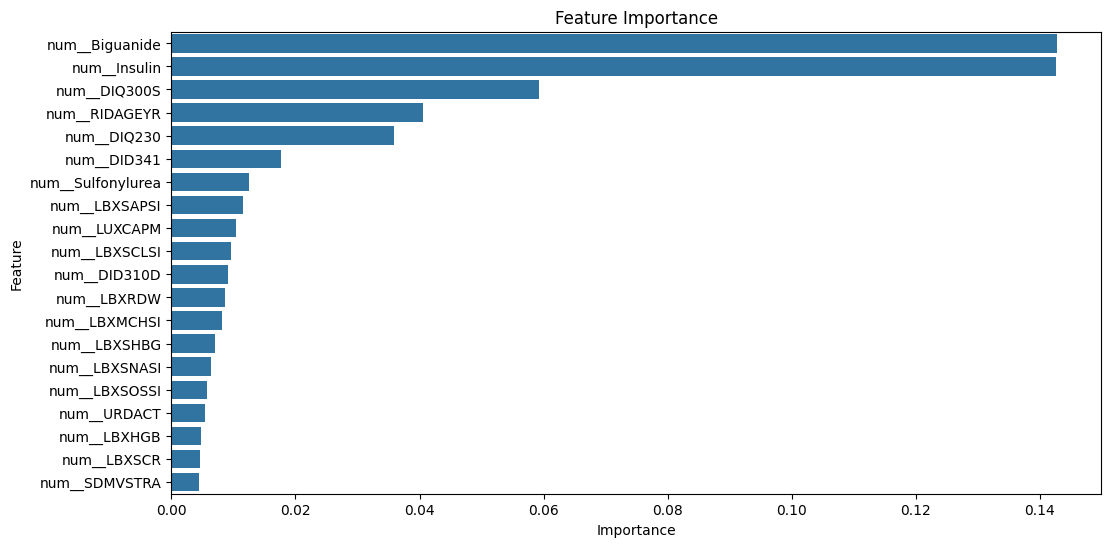

In [27]:
# Feature importance
importances = model.named_steps['rf'].feature_importances_
feature_names = model.named_steps['prep'].get_feature_names_out()

import matplotlib.pyplot as plt
import seaborn as sns

# Create a plot for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)
print(feature_importance_df)

# top 20 features
feature_importance_df = feature_importance_df.head(20)
plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importance_df, x='Importance', y='Feature')
plt.title('Feature Importance')
plt.show()